In [18]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [19]:
file_path="processed_dataset.csv"
df=pd.read_csv(file_path)

In [20]:
df_prophet=df[['date', 'demand']].rename(columns={'date': 'ds', 'demand': 'y'})
df_prophet['ds']=pd.to_datetime(df_prophet['ds'])

In [21]:
train_size=int(0.8*len(df_prophet))
train_df, test_df=df_prophet[:train_size], df_prophet[train_size:]
model = Prophet()
model.fit(train_df)

17:49:45 - cmdstanpy - INFO - Chain [1] start processing
17:49:45 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
future = model.make_future_dataframe(periods=len(test_df))
forecast = model.predict(future)

In [23]:
preds = forecast[['ds', 'yhat']].set_index('ds').loc[test_df['ds']].reset_index()
#yhat represents the predicted values generated by the model.
mae = mean_absolute_error(test_df['y'], preds['yhat'])
rmse = np.sqrt(mean_squared_error(test_df['y'], preds['yhat']))

# Before adding external regressors..

In [24]:
print("Prophet model without external regressors:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

Prophet model without external regressors:
MAE: 6698.78
RMSE: 8807.14


In [25]:
external_regressors = [
    'RRP', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall',
    'school_day_N', 'school_day_Y', 'holiday_N', 'holiday_Y'
]

In [26]:
df_prophet[external_regressors] = df[external_regressors]

train_df, test_df=df_prophet[:train_size], df_prophet[train_size:]

In [27]:
model_with_regressors=Prophet()
for reg in external_regressors:
    model_with_regressors.add_regressor(reg)

In [28]:
model_with_regressors.fit(train_df)

future_with_regressors=model_with_regressors.make_future_dataframe(periods=len(test_df))
future_with_regressors=future_with_regressors.merge(df_prophet[['ds'] + external_regressors], on='ds', how='left')

17:49:46 - cmdstanpy - INFO - Chain [1] start processing
17:49:47 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
forecast_with_regressors=model_with_regressors.predict(future_with_regressors)

preds_with_regressors=forecast_with_regressors[['ds', 'yhat']].set_index('ds').loc[test_df['ds']].reset_index()

mae_with_regressors=mean_absolute_error(test_df['y'], preds_with_regressors['yhat'])
rmse_with_regressors=np.sqrt(mean_squared_error(test_df['y'], preds_with_regressors['yhat']))

# After adding external regressors...

In [30]:
print("Prophet Model with external regressors:")
print(f"MAE:{mae_with_regressors:.2f}")
print(f"RMSE: {rmse_with_regressors:.2f}")

Prophet Model with external regressors:
MAE:6447.86
RMSE: 7932.52


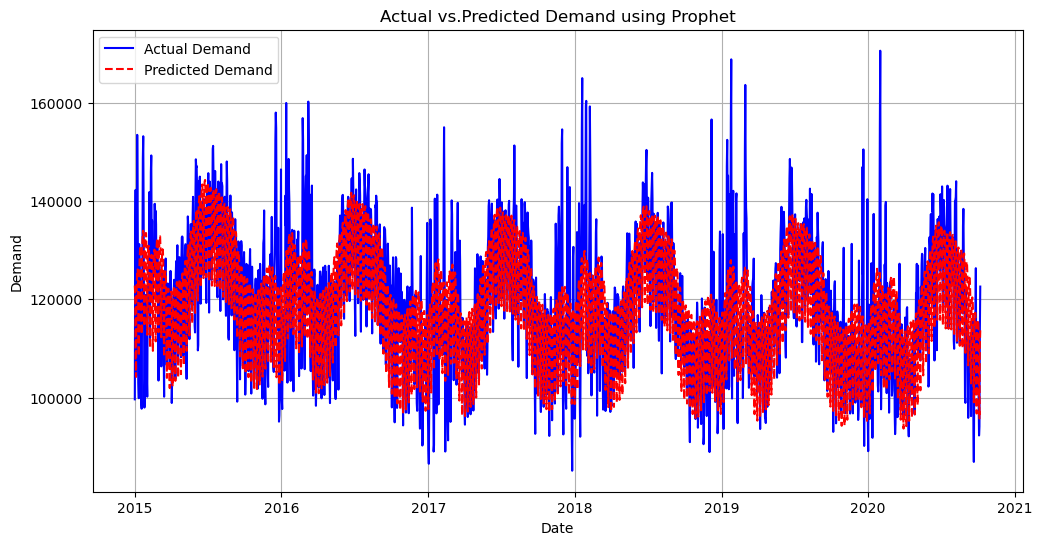

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label="Actual Demand", color="blue")
plt.plot(forecast['ds'], forecast['yhat'], label="Predicted Demand", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Actual vs.Predicted Demand using Prophet")
plt.legend()
plt.grid(True)
plt.show()

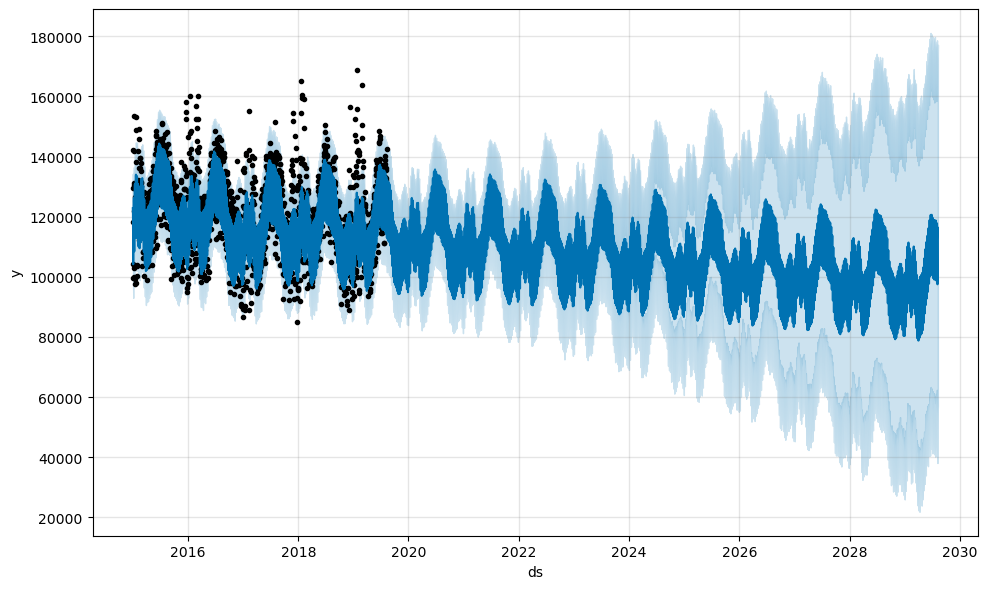

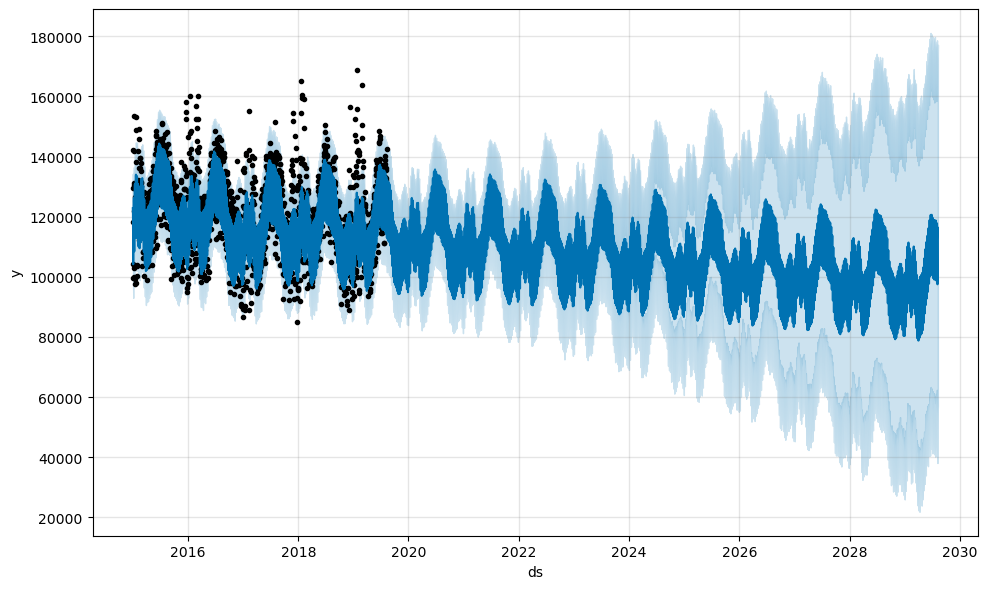

In [37]:
future_10y=model.make_future_dataframe(periods=365*10)
forecast_10y=model.predict(future_10y)
model.plot(forecast_10y)

# CONCLUSION

# Adding external regressors enhances Prophet’s predictive power when chosen correctly, but requires careful selection and preprocessing 